# データ
ここでは現実のデータではなく[VKITTI2](https://europe.naverlabs.com/research/computer-vision/proxy-virtual-worlds-vkitti-2/)というシミュレータにより作成されたCGを使う。
現実のデータより扱いやすいためである。

RGB、Depth、Camera parametersを上記のリンク先からダウロードしてほしい。

今回は教師データを使わずに学習するが、実装途中でデバッグとvalidationスコアの測定のためにDepth、Camera Parametersを使う予定である。
ちなみに、RGB画像とDepthで合計14GB程度あるので、ダウンロードに時間がかかる点に注意されたい。

tarを`data/`の下にダウロードしたとしよう。
tarを展開すると以下のディレクトリ構成になり、シーンごとにフォルダが別れていることがわかる。
```
$ tree -L 1
.
├── Scene01
├── Scene02
├── Scene06
├── Scene18
├── Scene20
└── vkitti_2.0.3_textgt
```

さらに`Scene*`の下にはdepth, rgbが格納されたディレクトリを包含するディレクトリがいくつか存在する。

```
$ tree Scene01/ -L 3 | head 5
Scene01/
├── 15-deg-left
│   └── frames
│       ├── depth
│       └── rgb
```

これに対応して`vkitti_2.0.3_textgt/`にbounding boxの真値や、カメラパラメタ（intrinsics.txt, extrinsics.txt）、カメラの位置、姿勢(pose.txt)が入っている。
```
$ tree vkitti_2.0.3_textgt/Scene01/ -L 2 | head -8
vkitti_2.0.3_textgt/Scene01/
├── 15-deg-left
│   ├── bbox.txt
│   ├── colors.txt
│   ├── extrinsic.txt
│   ├── info.txt
│   ├── intrinsic.txt
│   └── pose.txt
```

ここではデータを一つずつ確認し、それぞれの扱い方を学ぶ。


# RGB
RGBはカメラで撮影された画像である。説明は不要だと思う。

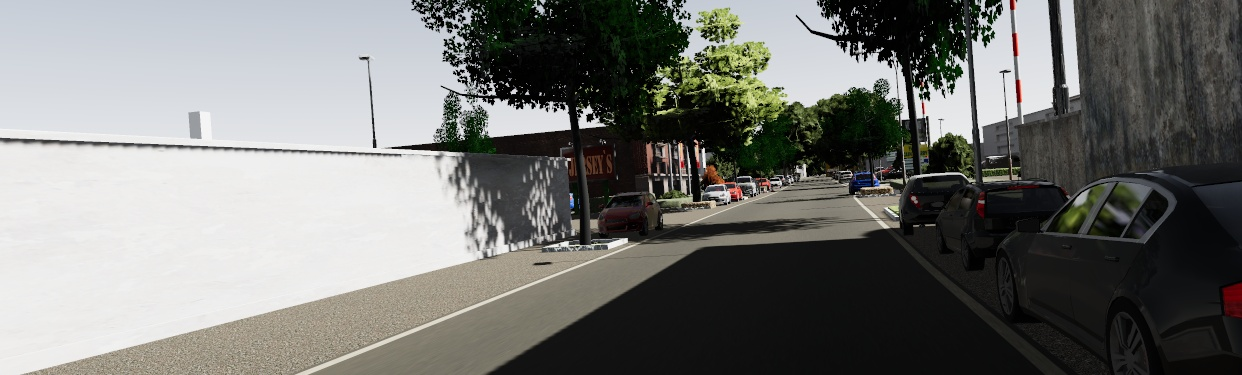

In [30]:
from PIL import Image

Image.open("../data/Scene01/15-deg-left/frames/rgb/Camera_0/rgb_00000.jpg")

# Depth
上のRGBに対応するDepthを表示する。
Depthは8bitでは距離を表すのには不足であるため、16bitになっている点に注意。

<PIL.PngImagePlugin.PngImageFile image mode=I size=1242x375 at 0x11A4417B8>


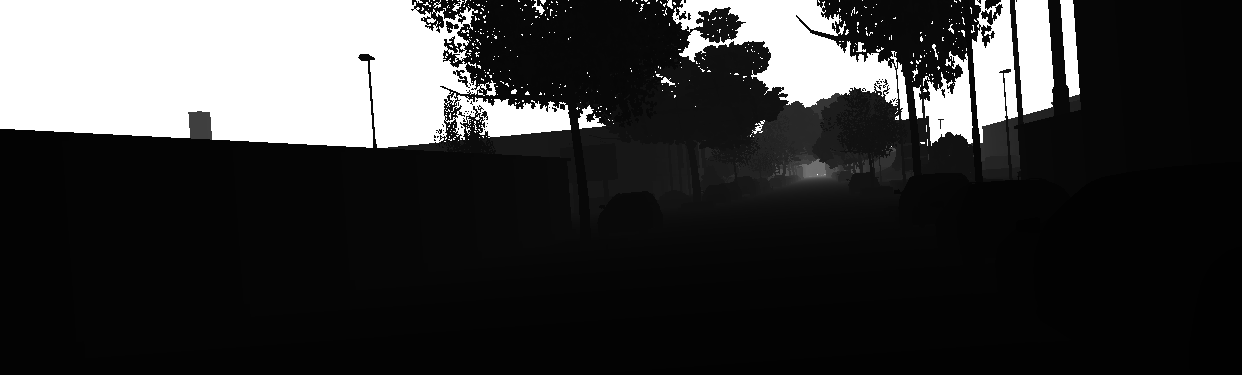

In [31]:
depth = Image.open("../data/Scene01/15-deg-left/frames/depth/Camera_0/depth_00000.png")
print(depth)
depth

# カメラの外部パラメタ（Extrinsics）
カメラの外部パラメタはカメラの取り付け角度・位置を表す。
カメラを扱う上で外部パラメタ、内部パラメタは基本的な知識であり様々な解説がすでにあるので、ここでは説明しないが、Mathworks社のページなどが参考になると思われる。

外部パラメタは4x3の行列にでき、行列・逆行列をかけることでワールド座標⇔カメラ座標を行き来することができる。
さらに内部パラメタと外部パラメタを組み合わせると、更にワールド座標⇔カメラ座標⇔画像座標を行き来することができる。
このノートの最後にRGB、深度が外部パラメタ、内部パラメタを組み合わせて隣接するフレームの間で画素を重ね合わせるデモを行うときに改めて外部パラメタには触れるので、ここでは簡単にデータを見るに留める。

In [32]:
import pandas as pd
import numpy as np

# 中身をみてみる
data = pd.read_csv("../data/vkitti_2.0.3_textgt/Scene01/15-deg-left/extrinsic.txt", delimiter=' ')
data

,frame,cameraID,"r1,1","r1,2","r1,3",t1,"r2,1","r2,2","r2,3",t2,"r3,1","r3,2","r3,3",t3,0,0.1,0.2,1
0,0,0,-0.008020,0.072179,-0.997359,7.494453,-0.000990,0.997390,0.072189,112.4036,0.999967,0.001566,-0.007927,-0.771782,0,0,0,1
1,0,1,-0.008020,0.072179,-0.997359,6.961728,-0.000990,0.997390,0.072189,112.4036,0.999967,0.001566,-0.007927,-0.771782,0,0,0,1
2,1,0,-0.007779,0.073074,-0.997296,7.283874,0.000694,0.997327,0.073071,112.4180,0.999969,-0.000124,-0.007809,-2.094175,0,0,0,1
3,1,1,-0.007779,0.073074,-0.997296,6.751150,0.000694,0.997327,0.073071,112.4180,0.999969,-0.000124,-0.007809,-2.094175,0,0,0,1
4,2,0,-0.008015,0.069713,-0.997535,6.626684,-0.001973,0.997564,0.069731,112.4692,0.999966,0.002527,-0.007858,-2.832348,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
889,444,1,0.958401,0.034313,-0.283355,-209.639700,-0.034897,0.999386,0.002991,120.8822,0.283284,0.007022,0.959010,-139.973900,0,0,0,1
890,445,0,0.958387,0.034334,-0.283400,-209.098000,-0.034896,0.999386,0.003066,120.8765,0.283331,0.006951,0.958997,-139.989800,0,0,0,1
891,445,1,0.958387,0.034334,-0.283400,-209.630700,-0.034896,0.999386,0.003066,120.8765,0.283331,0.006951,0.958997,-139.989800,0,0,0,1
892,446,0,0.958362,0.034361,-0.283481,-209.082600,-0.034930,0.999385,0.003050,120.8858,0.283411,0.006979,0.958973,-140.002100,0,0,0,1


In [51]:
# 写像用の行列を作成する
row0 = data.loc[0]

extrinsic = np.array([
    [row0["r1,1"], row0["r1,2"], row0["r1,3"], row0["t1"]],
    [row0["r2,1"], row0["r2,2"], row0["r2,3"], row0["t2"]],
    [row0["r3,1"], row0["r3,2"], row0["r3,3"], row0["t3"]],
    [row0["0"],    row0["0.1"],  row0["0.2"], row0["1"]]])
extrinsic

array([[-8.019686e-03,  7.217909e-02, -9.973595e-01,  7.494453e+00],
       [-9.896867e-04,  9.973904e-01,  7.218930e-02,  1.124036e+02],
       [ 9.999674e-01,  1.566000e-03, -7.927299e-03, -7.717823e-01],
       [ 0.000000e+00,  0.000000e+00,  0.000000e+00,  1.000000e+00]])

# カメラの内部パラメタ

In [34]:
# 中身をみてみる
data = pd.read_csv("../data/vkitti_2.0.3_textgt/Scene01/15-deg-left/intrinsic.txt", delimiter=' ')
data

,frame,cameraID,"K[0,0]","K[1,1]","K[0,2]","K[1,2]"
0,0,0,725.0087,725.0087,620.5,187
1,0,1,725.0087,725.0087,620.5,187
2,1,0,725.0087,725.0087,620.5,187
3,1,1,725.0087,725.0087,620.5,187
4,2,0,725.0087,725.0087,620.5,187
...,...,...,...,...,...,...
889,444,1,725.0087,725.0087,620.5,187
890,445,0,725.0087,725.0087,620.5,187
891,445,1,725.0087,725.0087,620.5,187
892,446,0,725.0087,725.0087,620.5,187


In [35]:
# 写像用の行列を作成する
row0 = data.loc[0]

intrinsic = np.array([
    [row0["K[0,0]"],            0.0, row0["K[0,2]"]],
    [           0.0, row0["K[1,1]"], row0["K[1,2]"]],
    [           0.0,            0.0,           1.0]])
intrinsic

array([[725.0087,   0.    , 620.5   ],
       [  0.    , 725.0087, 187.    ],
       [  0.    ,   0.    ,   1.    ]])

これで今回使うであろうデータの中身はすべて確認したことになる。

最後にこれらをすべて使い、あるフレームの画素を隣のフレームに合わせこんでみる。
これはPhotometric lossを計算する上で必要な処理である。

まず隣接する２フレームを表示してみる。
一見してこれらはあまり見た目上の違いがないように見える。

In [36]:
image_t0 = Image.open("../data/Scene01/15-deg-left/frames/rgb/Camera_0/rgb_00000.jpg")
image_t1 = Image.open("../data/Scene01/15-deg-left/frames/rgb/Camera_0/rgb_00001.jpg")

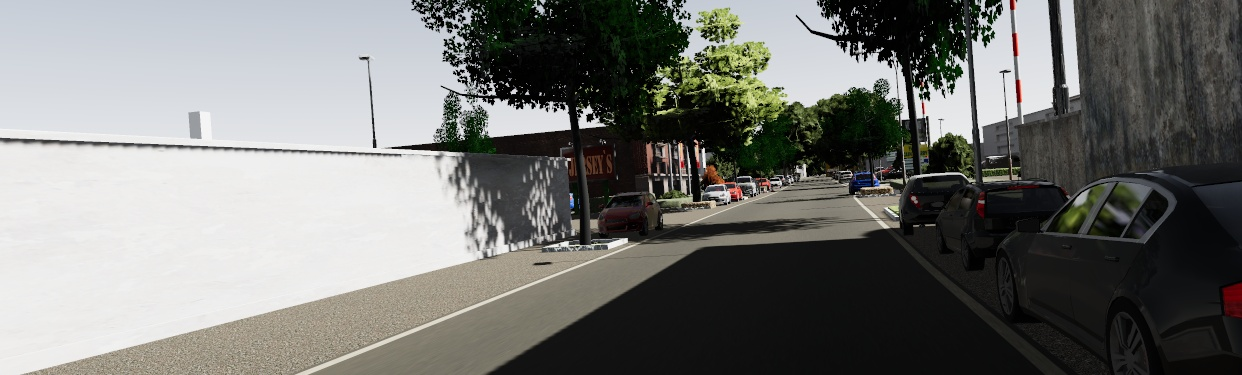

In [37]:
image_t0

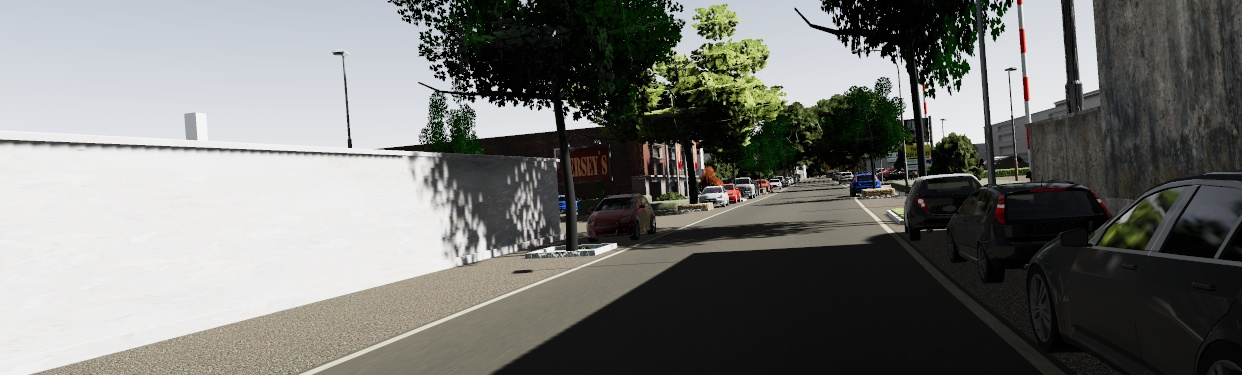

In [38]:
image_t1

しかし、実際は自車両が移動しているため、画素レベルでは大きな違いが生じている。
これを画素の差分で確認する。

In [39]:
image_t0, image_t1 = np.array(image_t0), np.array(image_t1)

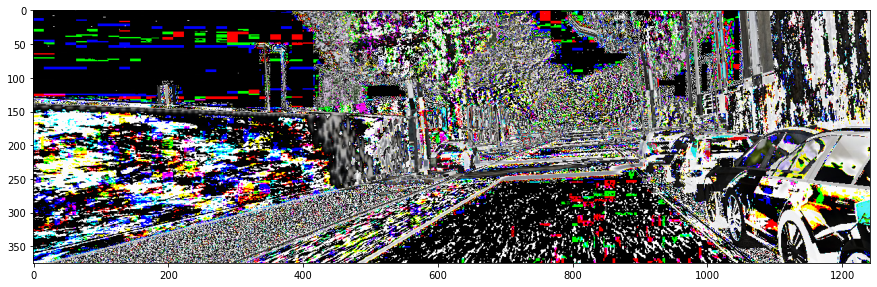

In [40]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 15))
plt.imshow(np.abs(image_t0 - image_t1))

黒い箇所は差が小さい場所だが、空と地面は比較的に差分が少ないことがわかる。

ここからDepth、カメラパラメタをつかって重ね合わせていく。
今回は0番目のフレームを1番目のフレームに合わせることにする。

カメラの投影のカメラ座標（３次元）から画像平面（２次元）への投影であり、以下のように内部パラメタ・外部パラメタの行列をかけることで計算される。
![projection](../assets/projection.png)

http://opencv.jp/opencv-2.1/cpp/camera_calibration_and_3d_reconstruction.html

0フレーム目から1フレーム目への投影は画像平面同士の射影であるが、画像平面→カメラ座標→ワールド座標→カメラ座標→画像平面の順に座標を変換することで、この投影を行う。
画像平面→カメラ平面の射影は2Dから3Dへの射影であり、画像化されたときに失われた次元を復元するために深度が必要である。

In [62]:
# 写像用の行列を作成する
data = pd.read_csv("../data/vkitti_2.0.3_textgt/Scene01/15-deg-left/extrinsic.txt", delimiter=' ')

row_t0 = data.loc[0]  # frame #0, cameraID #0
row_t1 = data.loc[2]  # frame #1, cameraID #0

extrinsic_t0 = np.array([
    [row_t0["r1,1"], row_t0["r1,2"], row_t0["r1,3"], row_t0["t1"]],
    [row_t0["r2,1"], row_t0["r2,2"], row_t0["r2,3"], row_t0["t2"]],
    [row_t0["r3,1"], row_t0["r3,2"], row_t0["r3,3"], row_t0["t3"]],
    [row_t0["0"],    row_t0["0.1"],  row_t0["0.2"],  row_t0["1"]]])

extrinsic_t0 = np.array([
    [row_t1["r1,1"], row_t1["r1,2"], row_t1["r1,3"], row_t1["t1"]],
    [row_t1["r2,1"], row_t1["r2,2"], row_t1["r2,3"], row_t1["t2"]],
    [row_t1["r3,1"], row_t1["r3,2"], row_t1["r3,3"], row_t1["t3"]],
    [row_t1["0"],    row_t1["0.1"],  row_t1["0.2"],  row_t1["1"]]])

In [73]:
camera_coord = extrinsic @ np.array([0, 0, 0, 1]).T
print(camera_coord)

image_coord = intrinsic @ camera_coord[:3].T
image_coord /= image_coord[2]
print(image_coord)

[  7.494453  112.4036     -0.7717823   1.       ]
[-6.41975426e+03 -1.05404419e+05  1.00000000e+00]


In [75]:
intrinsic_inv = np.linalg.inv(intrinsic)
extrinsic_t0_inv = np.linalg.inv(extrinsic_t0)

In [91]:
depth = np.array(depth)

In [106]:
center_coord = (depth.shape[1] / 2, depth.shape[0] / 2, 0)
center_coord

(621.0, 187.5, 0)

In [119]:
xi = np.arange(0, depth.shape[1], 1)
yi = np.arange(0, depth.shape[0], 1)
coord_x, coord_y = np.meshgrid(xi, yi)
coord_z = np.ones_like(coord_x)
image_coords = np.stack([coord_x, coord_y, coord_z], axis=-1)
image_coords = image_coords.astype(np.float64)
image_coords -= center_coord

image_coords.shape, depth.shape


((375, 1242, 3), (375, 1242))

In [124]:
camera_coord = image_coords @ intrinsic_inv.T
camera_coord.shape

(375, 1242, 3)

In [125]:
camera_coord  *= np.stack([depth, depth, depth], axis=-1)

In [137]:
camera_coord.shape

(375, 1242, 3)

In [136]:
world_coord = camera_coord @ extrinsic_t0_inv[:3, :].T

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 4 is different from 3)